In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import hstack
from sklearn.ensemble import VotingRegressor

!pip install catboost
from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

!pip install lightgbm
from lightgbm import LGBMRegressor

import xgboost as xgb

     |████████████████████████████████| 76.3 MB 55 kB/s 


In [ ]:
def preprocessing_data(df: pd.DataFrame, train: bool()) -> tuple():
    """ Data preproccessing """

    df.drop(columns='id', inplace=True)

    # приводим дату к типу даты
    df["date"] = pd.DatetimeIndex(df["date"])

    df.build_tech = df.build_tech.fillna(value=df.g_lift.median())

    df.g_lift = df.g_lift.fillna(value=df.g_lift.median())
    
    df.metro_dist = df.metro_dist.fillna(value=df.metro_dist.mean())

    df.build_tech[99999] = 1.0

    df = df.astype({'build_tech' : 'Int64',
                    'g_lift' : 'Int64'})

    df.build_tech.apply(lambda x: int(x))

    df.g_lift.apply(lambda x: int(x))

    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month

    df = pd.concat([df, pd.get_dummies(df.month, prefix='month')], axis=1)

    df = pd.concat([df, pd.get_dummies(df.floor, prefix='floor')], axis=1)

    df = pd.concat([df, pd.get_dummies(df.rooms, prefix='rooms')], axis=1)

    df = df.drop(columns=['date', 'floor', 'n_photos', 'rooms', 'month'])

    return df

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/d3vyatk4ru/DZ5ML/main/Train.csv')

In [ ]:
df

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,30,0.0,10,48,2,0,30.0,NaN,4,0,1,0,0,0,0,0,0,0,0,0,0,0,4252000
1,1,2011-1,376,1.0,2,53,2,0,30.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4463000
2,2,2011-1,549,NaN,8,61,3,1,30.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4518000
3,3,2011-1,321,1.0,10,47,1,1,30.0,0.0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,6785000
4,4,2011-1,636,NaN,3,58,3,0,25.0,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1677000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,2012-3,327,0.0,9,37,1,0,25.0,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,3198000
99996,99996,2012-3,249,0.0,2,33,1,0,20.0,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2366000
99997,99997,2012-3,537,NaN,3,61,3,0,30.0,NaN,6,1,1,0,0,0,0,0,0,0,0,0,0,0,3816000
99998,99998,2012-3,425,1.0,4,35,1,1,10.0,0.0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,3410000


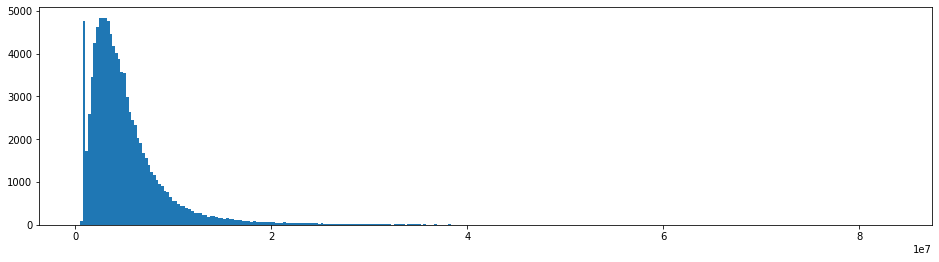

In [ ]:
plt.figure(figsize=(16, 4))
plt.hist(df.price, bins=300);

In [ ]:
df = df[~df.isnull()]

In [ ]:
df = preprocessing_data(df, train=False)

In [ ]:
df = df[df.price != 1_000_000]

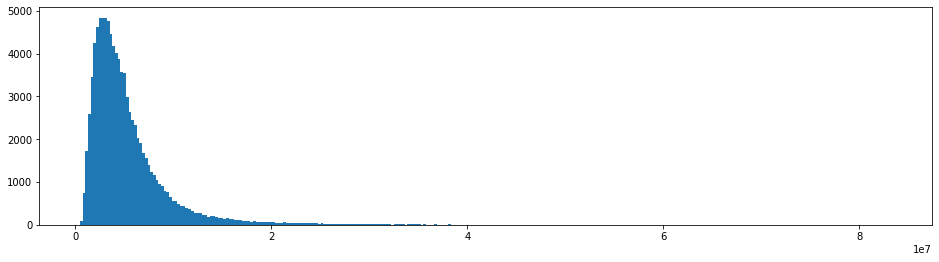

In [ ]:
plt.figure(figsize=(16, 4))
plt.hist(df.price, bins=300);

In [ ]:
y = df.price.values
X = df.drop(columns='price').values
del df

In [ ]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

In [ ]:
quadratic = PolynomialFeatures(degree=2)

In [ ]:
X_q = quadratic.fit_transform(X_scaler)
del X_scaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_q, y, test_size=0.15, random_state=42)
del X_q

In [ ]:
LGBM = LGBMRegressor(learning_rate=0.6,
                   n_estimators=250,
                   random_state=42,
                   num_leaves=1024,
                   reg_alpha=1e-2,
                   reg_lambda=1e-2)


catboostRMSE = CatBoostRegressor(learning_rate=0.8,
                          n_estimators=300,
                          loss_function="RMSE",
                          score_function='L2',
                          random_state=24,
                          reg_lambda=10)

catboostMAE = CatBoostRegressor(learning_rate=0.8,
                          n_estimators=300,
                          loss_function="MAE",
                          random_state=42,
                          reg_lambda=1e+2)

In [ ]:
voting = VotingRegressor([('LGBM', LGBM), ('catboostRMSE', catboostRMSE), ('catboostMAE', catboostMAE)])

In [ ]:
voting.fit(X_train, y_train)

0:	learn: 3348203.3575898	total: 675ms	remaining: 5m 36s
1:	learn: 2969182.7906683	total: 1.26s	remaining: 5m 12s
2:	learn: 2822466.3324597	total: 1.83s	remaining: 5m 4s
3:	learn: 2716975.5560885	total: 2.34s	remaining: 4m 49s
4:	learn: 2670684.2143680	total: 3s	remaining: 4m 57s
5:	learn: 2630702.2746914	total: 3.45s	remaining: 4m 44s
6:	learn: 2581420.2070823	total: 3.96s	remaining: 4m 39s
7:	learn: 2561453.4019007	total: 4.59s	remaining: 4m 42s
8:	learn: 2538206.6783381	total: 5.08s	remaining: 4m 36s
9:	learn: 2506784.6091432	total: 5.68s	remaining: 4m 38s
10:	learn: 2476228.7740770	total: 6.12s	remaining: 4m 31s
11:	learn: 2446947.7396188	total: 6.71s	remaining: 4m 32s
12:	learn: 2396410.2354075	total: 7.28s	remaining: 4m 32s
13:	learn: 2377860.4848277	total: 7.82s	remaining: 4m 31s
14:	learn: 2366369.0600221	total: 8.39s	remaining: 4m 31s
15:	learn: 2357411.7353451	total: 8.94s	remaining: 4m 30s
16:	learn: 2344101.7586392	total: 9.66s	remaining: 4m 34s
17:	learn: 2328393.7358693	t

VotingRegressor(estimators=[('LGBM',
                             LGBMRegressor(learning_rate=0.11, n_estimators=250,
                                           num_leaves=1024, random_state=42,
                                           reg_alpha=0.01, reg_lambda=0.01)),
                            ('catboostRMSE',
                             <catboost.core.CatBoostRegressor object at 0x7f68ab9114d0>),
                            ('catboostMAE',
                             <catboost.core.CatBoostRegressor object at 0x7f68ab911910>)])

In [ ]:
y_pred = voting.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
print(abs(y_pred - y_test)).mean()
print(abs(y_pred - y_test)).max()
print(abs(y_pred - y_test).min())

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/d3vyatk4ru/DZ5ML/main/Test.csv')
y = df_test.id.values

In [ ]:
df_test = preprocessing_data(df_test, train=False)

In [ ]:
X = df_test.values

In [ ]:
X_test_scaler = scaler.transform(X)

In [ ]:
X_test_quadratic = quadratic.transform(X_test_scaler)

In [ ]:
y_tmp = voting.predict(X_test_quadratic)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.DataFrame()
df['id'] = y
df['price'] = y_prev.price
df.to_csv("/content/drive/MyDrive/price_flat_night0412+300k.csv", index=False)